In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle, class_weight
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v3 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_1overlap/ATAC/"

seq_names = ["ATAC", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [3]:
with open(args.in_dir + "hg38_signals.pickle", 'rb') as f:
    X, Y = pickle.load(f)
window_size = int(X.shape[2] * 10)
X, Y = shuffle(X, Y, random_state=0)
x_train = np.expand_dims(X, axis=4)
y_train = Y

#calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train.flatten())

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


In [4]:
# construct the model
model = create_model(width=int(window_size/10))
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
    metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

# if os.path.exists('./saved_models/ATAC_hg38.v3.h5'):
#     model.load_weights('./saved_models/ATAC_hg38.v3.h5')
# else:
#     #train the model
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    shuffle=True,
                    class_weight=class_weights,
                    callbacks=[es]) 

model.save_weights('./saved_models/ATAC_hg38.v3.h5')

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 372853 samples, validate on 41429 samples
Epoch 1/100
372853/372853 [==============================] - 330s 886us/step - loss: 0.1050 - acc: 0.9507 - auroc: 0.9464 - auprc: 0.6973 - f1_m: 0.6512 - recall_m: 0.6835 - precision_m: 0.6779 - val_loss: 0.0885 - val_acc: 0.9560 - val_auroc: 0.9787 - val_auprc: 0.7950 - val_f1_m: 0.6966 - val_recall_m: 0.7112 - val_precision_m: 0.7390
Epoch 2/100
372853/372853 [==============================] - 328s 878us/step - loss: 0.0879 - acc: 0.9566 - auroc: 0.9805 - auprc: 0.8082 - f1_m: 0.7032 - recall_m: 0.7434 - precision_m: 0.7195 - val_loss: 0.0858 - val_acc: 0.9580 - val_auroc: 0.9817 - val_auprc: 0.8172 - val_f1_m: 0.7247 - val_recall_m: 0.7735 - val_precision_m: 0.7311
Epoch 3/100
372853/372853 [==============================] - 328s 878us/step - loss: 0.0855 - acc: 0.9581 - auroc: 0.9824 - auprc: 0.8229 - f1_m: 0.7119 - recall_m: 0.7511 - precision_m: 0.7281 - val_loss: 0.0863 - val_acc: 0.9575 - val_auroc: 0.9829 - val_auprc: 0.8276 

In [5]:
with open("./mm10/mm10_all_signals.pickle", 'rb') as f:
    X,Y = pickle.load(f)
samples = ["forebrain", "heart", "hindbrain", "limb", "midbrain", "neural tube"]

In [6]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    y_pred = model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

forebrain validation accuracy is: 0.7345869297163995
heart validation accuracy is: 0.7607891491985204
hindbrain validation accuracy is: 0.7389025893958077
limb validation accuracy is: 0.748766954377312
midbrain validation accuracy is: 0.7413686806411838
neural tube validation accuracy is: 0.7228729963008631


6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


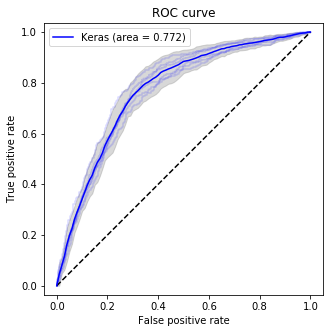

In [7]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


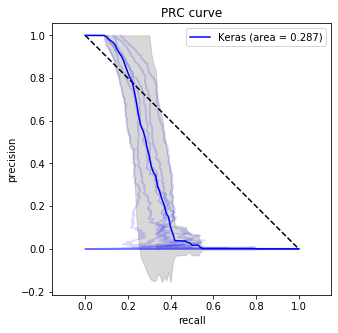

In [8]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [9]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))
    
print("\n")

for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))

validated tissue forebrain auROC: 0.7823147030758869
validated tissue heart auROC: 0.8035940539866795
validated tissue hindbrain auROC: 0.7630165480500247
validated tissue limb auROC: 0.752060908427002
validated tissue midbrain auROC: 0.7782510697424723
validated tissue neural tube auROC: 0.7505257898743815


validated tissue forebrain auPRC: 0.35268668493993766
validated tissue heart auPRC: 0.2899003557741856
validated tissue hindbrain auPRC: 0.2956971973246994
validated tissue limb auPRC: 0.2583978661114664
validated tissue midbrain auPRC: 0.31917572190502425
validated tissue neural tube auPRC: 0.20366102256059557


In [10]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    
    #fine-tuning
    X_ft = X.copy()
    X_ft.pop(i)
    X_ft = np.array(X_ft)
    X_ft = X_ft.reshape((-1, X_ft.shape[2], X_ft.shape[3], X_ft.shape[4]))
    
    Y_ft = Y.copy()
    Y_ft.pop(i)
    Y_ft = np.array(Y_ft)
    Y_ft = Y_ft.reshape((-1, 1))
    
    X_ft, Y_ft = shuffle(X_ft, Y_ft, random_state=0)
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_ft),
                                                  Y_ft.flatten())
    
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    ft_model = create_model(width=int(window_size/10))
    ft_model.load_weights('./saved_models/ATAC_hg38.v3.h5')
    ft_model.compile(loss='binary_crossentropy', 
                     optimizer=Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5), 
                     metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
    
    #train the model
    history = ft_model.fit(X_ft, Y_ft,
                        batch_size=4,
                        epochs=150,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es])
    
    y_pred = ft_model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v3.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 14598 samples, validate on 1622 samples
Epoch 1/150
14598/14598 [==============================] - 59s 4ms/step - loss: 0.4092 - acc: 0.8537 - auroc: 0.7600 - auprc: 0.2532 - f1_m: 0.0746 - recall_m: 0.0788 - precision_m: 0.0771 - val_loss: 0.3123 - val_acc: 0.8884 - val_auroc: 0.7546 - val_auprc: 0.2514 - val_f1_m: 0.0362 - val_recall_m: 0.0358 - val_precision_m: 0.0370
Epoch 2/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3397 - acc: 0.8858 - auroc: 0.7570 - auprc: 0.2561 - f1_m: 0.0308 - recall_m: 0.0300 - precision_m: 0.0332 - val_loss: 0.2950 - val_acc: 0.8946 - val_auroc: 0.7598 - val_auprc: 0.2625 - val_f1_m: 0.0395 - val_recall_m: 0.0395 - val_precision_m: 0.0407
Epoch 3/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3214 - acc: 0.8870 - auroc: 0.7620 - auprc: 0.2693 - f1_m: 0.0356 - recall_m: 0.0335 - precision_m: 0.0401 - val_loss: 0.2866 - val_acc: 0.8933 - val_auroc: 0.7644 - val_auprc: 0.2749 - val_f1_m: 0.041

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2816 - acc: 0.8934 - auroc: 0.7996 - auprc: 0.3646 - f1_m: 0.0768 - recall_m: 0.0745 - precision_m: 0.0836 - val_loss: 0.2599 - val_acc: 0.8940 - val_auroc: 0.7998 - val_auprc: 0.3653 - val_f1_m: 0.0654 - val_recall_m: 0.0629 - val_precision_m: 0.0703
Epoch 26/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2816 - acc: 0.8933 - auroc: 0.8001 - auprc: 0.3659 - f1_m: 0.0778 - recall_m: 0.0759 - precision_m: 0.0840 - val_loss: 0.2597 - val_acc: 0.8946 - val_auroc: 0.8003 - val_auprc: 0.3665 - val_f1_m: 0.0670 - val_recall_m: 0.0641 - val_precision_m: 0.0727
Epoch 27/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2810 - acc: 0.8935 - auroc: 0.8004 - auprc: 0.3670 - f1_m: 0.0783 - recall_m: 0.0761 - precision_m: 0.0847 - val_loss: 0.2595 - val_acc: 0.8940 - val_auroc: 0.8008 - val_auprc: 0.3678 - val_f1_m: 0.0670 - val_recall_m: 0.0641 - val_precision_m: 0.0727
Epoch 28

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2772 - acc: 0.8938 - auroc: 0.8081 - auprc: 0.3849 - f1_m: 0.0826 - recall_m: 0.0805 - precision_m: 0.0886 - val_loss: 0.2565 - val_acc: 0.8946 - val_auroc: 0.8082 - val_auprc: 0.3852 - val_f1_m: 0.0723 - val_recall_m: 0.0686 - val_precision_m: 0.0801
Epoch 50/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2782 - acc: 0.8940 - auroc: 0.8083 - auprc: 0.3856 - f1_m: 0.0831 - recall_m: 0.0810 - precision_m: 0.0893 - val_loss: 0.2564 - val_acc: 0.8946 - val_auroc: 0.8084 - val_auprc: 0.3857 - val_f1_m: 0.0723 - val_recall_m: 0.0686 - val_precision_m: 0.0801
Epoch 51/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2771 - acc: 0.8940 - auroc: 0.8085 - auprc: 0.3859 - f1_m: 0.0819 - recall_m: 0.0789 - precision_m: 0.0896 - val_loss: 0.2563 - val_acc: 0.8946 - val_auroc: 0.8086 - val_auprc: 0.3862 - val_f1_m: 0.0723 - val_recall_m: 0.0686 - val_precision_m: 0.0801
Epoch 52

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2764 - acc: 0.8942 - auroc: 0.8121 - auprc: 0.3944 - f1_m: 0.0842 - recall_m: 0.0814 - precision_m: 0.0912 - val_loss: 0.2549 - val_acc: 0.8970 - val_auroc: 0.8121 - val_auprc: 0.3946 - val_f1_m: 0.0789 - val_recall_m: 0.0760 - val_precision_m: 0.0863
Epoch 74/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2757 - acc: 0.8934 - auroc: 0.8122 - auprc: 0.3947 - f1_m: 0.0807 - recall_m: 0.0788 - precision_m: 0.0876 - val_loss: 0.2548 - val_acc: 0.8970 - val_auroc: 0.8123 - val_auprc: 0.3949 - val_f1_m: 0.0789 - val_recall_m: 0.0760 - val_precision_m: 0.0863
Epoch 75/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2761 - acc: 0.8945 - auroc: 0.8123 - auprc: 0.3950 - f1_m: 0.0843 - recall_m: 0.0821 - precision_m: 0.0908 - val_loss: 0.2548 - val_acc: 0.8970 - val_auroc: 0.8124 - val_auprc: 0.3952 - val_f1_m: 0.0789 - val_recall_m: 0.0760 - val_precision_m: 0.0863
Epoch 76

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2750 - acc: 0.8933 - auroc: 0.8146 - auprc: 0.4006 - f1_m: 0.0825 - recall_m: 0.0802 - precision_m: 0.0900 - val_loss: 0.2539 - val_acc: 0.8964 - val_auroc: 0.8146 - val_auprc: 0.4006 - val_f1_m: 0.0764 - val_recall_m: 0.0736 - val_precision_m: 0.0838
Epoch 98/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2746 - acc: 0.8942 - auroc: 0.8147 - auprc: 0.4007 - f1_m: 0.0811 - recall_m: 0.0778 - precision_m: 0.0891 - val_loss: 0.2538 - val_acc: 0.8964 - val_auroc: 0.8147 - val_auprc: 0.4008 - val_f1_m: 0.0764 - val_recall_m: 0.0736 - val_precision_m: 0.0838
Epoch 99/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2747 - acc: 0.8940 - auroc: 0.8148 - auprc: 0.4009 - f1_m: 0.0835 - recall_m: 0.0806 - precision_m: 0.0918 - val_loss: 0.2538 - val_acc: 0.8964 - val_auroc: 0.8148 - val_auprc: 0.4010 - val_f1_m: 0.0764 - val_recall_m: 0.0736 - val_precision_m: 0.0838
Epoch 10

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2747 - acc: 0.8943 - auroc: 0.8164 - auprc: 0.4048 - f1_m: 0.0846 - recall_m: 0.0821 - precision_m: 0.0919 - val_loss: 0.2532 - val_acc: 0.8970 - val_auroc: 0.8164 - val_auprc: 0.4049 - val_f1_m: 0.0764 - val_recall_m: 0.0736 - val_precision_m: 0.0838
Epoch 122/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2746 - acc: 0.8948 - auroc: 0.8164 - auprc: 0.4049 - f1_m: 0.0822 - recall_m: 0.0795 - precision_m: 0.0901 - val_loss: 0.2531 - val_acc: 0.8970 - val_auroc: 0.8164 - val_auprc: 0.4050 - val_f1_m: 0.0764 - val_recall_m: 0.0736 - val_precision_m: 0.0838
Epoch 123/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2738 - acc: 0.8938 - auroc: 0.8165 - auprc: 0.4051 - f1_m: 0.0832 - recall_m: 0.0816 - precision_m: 0.0889 - val_loss: 0.2531 - val_acc: 0.8970 - val_auroc: 0.8165 - val_auprc: 0.4051 - val_f1_m: 0.0764 - val_recall_m: 0.0736 - val_precision_m: 0.0838
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2744 - acc: 0.8944 - auroc: 0.8176 - auprc: 0.4080 - f1_m: 0.0867 - recall_m: 0.0842 - precision_m: 0.0933 - val_loss: 0.2526 - val_acc: 0.8983 - val_auroc: 0.8177 - val_auprc: 0.4080 - val_f1_m: 0.0789 - val_recall_m: 0.0760 - val_precision_m: 0.0863
Epoch 146/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2736 - acc: 0.8948 - auroc: 0.8177 - auprc: 0.4081 - f1_m: 0.0848 - recall_m: 0.0822 - precision_m: 0.0920 - val_loss: 0.2526 - val_acc: 0.8983 - val_auroc: 0.8177 - val_auprc: 0.4081 - val_f1_m: 0.0789 - val_recall_m: 0.0760 - val_precision_m: 0.0863
Epoch 147/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2741 - acc: 0.8946 - auroc: 0.8177 - auprc: 0.4082 - f1_m: 0.0838 - recall_m: 0.0814 - precision_m: 0.0917 - val_loss: 0.2526 - val_acc: 0.8983 - val_auroc: 0.8177 - val_auprc: 0.4083 - val_f1_m: 0.0789 - val_recall_m: 0.0760 - val_precision_m: 0.0863
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.3038 - acc: 0.8818 - auroc: 0.7938 - auprc: 0.3780 - f1_m: 0.0933 - recall_m: 0.0905 - precision_m: 0.1020 - val_loss: 0.2766 - val_acc: 0.8853 - val_auroc: 0.7943 - val_auprc: 0.3791 - val_f1_m: 0.0764 - val_recall_m: 0.0723 - val_precision_m: 0.0851
Epoch 20/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3026 - acc: 0.8822 - auroc: 0.7948 - auprc: 0.3805 - f1_m: 0.0970 - recall_m: 0.0937 - precision_m: 0.1062 - val_loss: 0.2762 - val_acc: 0.8847 - val_auroc: 0.7952 - val_auprc: 0.3811 - val_f1_m: 0.0764 - val_recall_m: 0.0723 - val_precision_m: 0.0851
Epoch 21/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3016 - acc: 0.8827 - auroc: 0.7956 - auprc: 0.3819 - f1_m: 0.0975 - recall_m: 0.0944 - precision_m: 0.1058 - val_loss: 0.2758 - val_acc: 0.8853 - val_auroc: 0.7961 - val_auprc: 0.3831 - val_f1_m: 0.0789 - val_recall_m: 0.0748 - val_precision_m: 0.0875
Epoch 22

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2976 - acc: 0.8829 - auroc: 0.8061 - auprc: 0.4076 - f1_m: 0.1048 - recall_m: 0.1030 - precision_m: 0.1126 - val_loss: 0.2708 - val_acc: 0.8866 - val_auroc: 0.8064 - val_auprc: 0.4081 - val_f1_m: 0.0855 - val_recall_m: 0.0822 - val_precision_m: 0.0937
Epoch 44/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2973 - acc: 0.8842 - auroc: 0.8065 - auprc: 0.4084 - f1_m: 0.0999 - recall_m: 0.0970 - precision_m: 0.1098 - val_loss: 0.2707 - val_acc: 0.8866 - val_auroc: 0.8066 - val_auprc: 0.4087 - val_f1_m: 0.0855 - val_recall_m: 0.0822 - val_precision_m: 0.0937
Epoch 45/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2968 - acc: 0.8839 - auroc: 0.8067 - auprc: 0.4091 - f1_m: 0.1027 - recall_m: 0.0994 - precision_m: 0.1131 - val_loss: 0.2705 - val_acc: 0.8866 - val_auroc: 0.8069 - val_auprc: 0.4094 - val_f1_m: 0.0855 - val_recall_m: 0.0822 - val_precision_m: 0.0937
Epoch 46

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2943 - acc: 0.8830 - auroc: 0.8113 - auprc: 0.4204 - f1_m: 0.1015 - recall_m: 0.0981 - precision_m: 0.1121 - val_loss: 0.2684 - val_acc: 0.8872 - val_auroc: 0.8114 - val_auprc: 0.4206 - val_f1_m: 0.0879 - val_recall_m: 0.0855 - val_precision_m: 0.0937
Epoch 68/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2952 - acc: 0.8836 - auroc: 0.8115 - auprc: 0.4208 - f1_m: 0.1044 - recall_m: 0.1019 - precision_m: 0.1137 - val_loss: 0.2683 - val_acc: 0.8872 - val_auroc: 0.8116 - val_auprc: 0.4210 - val_f1_m: 0.0879 - val_recall_m: 0.0855 - val_precision_m: 0.0937
Epoch 69/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2942 - acc: 0.8835 - auroc: 0.8116 - auprc: 0.4212 - f1_m: 0.1053 - recall_m: 0.1019 - precision_m: 0.1154 - val_loss: 0.2682 - val_acc: 0.8872 - val_auroc: 0.8117 - val_auprc: 0.4214 - val_f1_m: 0.0879 - val_recall_m: 0.0855 - val_precision_m: 0.0937
Epoch 70

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2934 - acc: 0.8835 - auroc: 0.8145 - auprc: 0.4284 - f1_m: 0.1051 - recall_m: 0.1028 - precision_m: 0.1140 - val_loss: 0.2668 - val_acc: 0.8878 - val_auroc: 0.8145 - val_auprc: 0.4285 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 92/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2929 - acc: 0.8842 - auroc: 0.8146 - auprc: 0.4286 - f1_m: 0.1063 - recall_m: 0.1042 - precision_m: 0.1144 - val_loss: 0.2667 - val_acc: 0.8878 - val_auroc: 0.8146 - val_auprc: 0.4288 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 93/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2935 - acc: 0.8838 - auroc: 0.8147 - auprc: 0.4289 - f1_m: 0.1040 - recall_m: 0.1015 - precision_m: 0.1134 - val_loss: 0.2667 - val_acc: 0.8878 - val_auroc: 0.8147 - val_auprc: 0.4290 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 94

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2920 - acc: 0.8846 - auroc: 0.8165 - auprc: 0.4338 - f1_m: 0.1071 - recall_m: 0.1044 - precision_m: 0.1162 - val_loss: 0.2657 - val_acc: 0.8878 - val_auroc: 0.8166 - val_auprc: 0.4339 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 116/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2925 - acc: 0.8847 - auroc: 0.8166 - auprc: 0.4340 - f1_m: 0.1049 - recall_m: 0.1017 - precision_m: 0.1148 - val_loss: 0.2657 - val_acc: 0.8878 - val_auroc: 0.8166 - val_auprc: 0.4341 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 117/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2922 - acc: 0.8844 - auroc: 0.8167 - auprc: 0.4342 - f1_m: 0.1047 - recall_m: 0.1013 - precision_m: 0.1144 - val_loss: 0.2656 - val_acc: 0.8878 - val_auroc: 0.8167 - val_auprc: 0.4343 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2916 - acc: 0.8848 - auroc: 0.8181 - auprc: 0.4378 - f1_m: 0.1071 - recall_m: 0.1037 - precision_m: 0.1175 - val_loss: 0.2649 - val_acc: 0.8872 - val_auroc: 0.8182 - val_auprc: 0.4379 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 140/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2911 - acc: 0.8855 - auroc: 0.8182 - auprc: 0.4380 - f1_m: 0.1091 - recall_m: 0.1052 - precision_m: 0.1198 - val_loss: 0.2649 - val_acc: 0.8872 - val_auroc: 0.8183 - val_auprc: 0.4381 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 141/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2914 - acc: 0.8842 - auroc: 0.8183 - auprc: 0.4381 - f1_m: 0.1027 - recall_m: 0.0993 - precision_m: 0.1129 - val_loss: 0.2648 - val_acc: 0.8872 - val_auroc: 0.8183 - val_auprc: 0.4382 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2918 - acc: 0.8872 - auroc: 0.8002 - auprc: 0.3639 - f1_m: 0.0863 - recall_m: 0.0832 - precision_m: 0.0951 - val_loss: 0.2728 - val_acc: 0.8890 - val_auroc: 0.8010 - val_auprc: 0.3655 - val_f1_m: 0.0748 - val_recall_m: 0.0711 - val_precision_m: 0.0826
Epoch 14/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2909 - acc: 0.8867 - auroc: 0.8015 - auprc: 0.3674 - f1_m: 0.0891 - recall_m: 0.0873 - precision_m: 0.0965 - val_loss: 0.2721 - val_acc: 0.8896 - val_auroc: 0.8022 - val_auprc: 0.3689 - val_f1_m: 0.0748 - val_recall_m: 0.0711 - val_precision_m: 0.0826
Epoch 15/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2897 - acc: 0.8868 - auroc: 0.8028 - auprc: 0.3709 - f1_m: 0.0906 - recall_m: 0.0891 - precision_m: 0.0969 - val_loss: 0.2715 - val_acc: 0.8896 - val_auroc: 0.8035 - val_auprc: 0.3721 - val_f1_m: 0.0748 - val_recall_m: 0.0711 - val_precision_m: 0.0826
Epoch 16

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2820 - acc: 0.8885 - auroc: 0.8167 - auprc: 0.4062 - f1_m: 0.1018 - recall_m: 0.0993 - precision_m: 0.1096 - val_loss: 0.2657 - val_acc: 0.8884 - val_auroc: 0.8169 - val_auprc: 0.4068 - val_f1_m: 0.0880 - val_recall_m: 0.0847 - val_precision_m: 0.0949
Epoch 38/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2813 - acc: 0.8892 - auroc: 0.8171 - auprc: 0.4073 - f1_m: 0.1041 - recall_m: 0.1023 - precision_m: 0.1110 - val_loss: 0.2656 - val_acc: 0.8884 - val_auroc: 0.8172 - val_auprc: 0.4077 - val_f1_m: 0.0880 - val_recall_m: 0.0847 - val_precision_m: 0.0949
Epoch 39/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2815 - acc: 0.8884 - auroc: 0.8175 - auprc: 0.4082 - f1_m: 0.1019 - recall_m: 0.0983 - precision_m: 0.1110 - val_loss: 0.2654 - val_acc: 0.8884 - val_auroc: 0.8176 - val_auprc: 0.4085 - val_f1_m: 0.0880 - val_recall_m: 0.0847 - val_precision_m: 0.0949
Epoch 40

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2787 - acc: 0.8894 - auroc: 0.8227 - auprc: 0.4218 - f1_m: 0.1001 - recall_m: 0.0974 - precision_m: 0.1091 - val_loss: 0.2633 - val_acc: 0.8890 - val_auroc: 0.8228 - val_auprc: 0.4221 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 62/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2793 - acc: 0.8896 - auroc: 0.8229 - auprc: 0.4223 - f1_m: 0.1021 - recall_m: 0.0989 - precision_m: 0.1113 - val_loss: 0.2632 - val_acc: 0.8890 - val_auroc: 0.8230 - val_auprc: 0.4225 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 63/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2796 - acc: 0.8891 - auroc: 0.8230 - auprc: 0.4228 - f1_m: 0.1030 - recall_m: 0.1004 - precision_m: 0.1112 - val_loss: 0.2631 - val_acc: 0.8884 - val_auroc: 0.8231 - val_auprc: 0.4229 - val_f1_m: 0.0903 - val_recall_m: 0.0880 - val_precision_m: 0.0962
Epoch 64

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2768 - acc: 0.8901 - auroc: 0.8259 - auprc: 0.4303 - f1_m: 0.1020 - recall_m: 0.0991 - precision_m: 0.1112 - val_loss: 0.2619 - val_acc: 0.8884 - val_auroc: 0.8260 - val_auprc: 0.4304 - val_f1_m: 0.0879 - val_recall_m: 0.0855 - val_precision_m: 0.0937
Epoch 86/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2777 - acc: 0.8893 - auroc: 0.8260 - auprc: 0.4306 - f1_m: 0.1026 - recall_m: 0.1000 - precision_m: 0.1110 - val_loss: 0.2618 - val_acc: 0.8884 - val_auroc: 0.8261 - val_auprc: 0.4307 - val_f1_m: 0.0879 - val_recall_m: 0.0855 - val_precision_m: 0.0937
Epoch 87/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2781 - acc: 0.8899 - auroc: 0.8261 - auprc: 0.4308 - f1_m: 0.1035 - recall_m: 0.1008 - precision_m: 0.1122 - val_loss: 0.2618 - val_acc: 0.8884 - val_auroc: 0.8262 - val_auprc: 0.4310 - val_f1_m: 0.0879 - val_recall_m: 0.0855 - val_precision_m: 0.0937
Epoch 88

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2771 - acc: 0.8897 - auroc: 0.8280 - auprc: 0.4361 - f1_m: 0.1031 - recall_m: 0.1003 - precision_m: 0.1116 - val_loss: 0.2610 - val_acc: 0.8884 - val_auroc: 0.8281 - val_auprc: 0.4363 - val_f1_m: 0.0895 - val_recall_m: 0.0867 - val_precision_m: 0.0962
Epoch 110/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2774 - acc: 0.8901 - auroc: 0.8281 - auprc: 0.4363 - f1_m: 0.1027 - recall_m: 0.0996 - precision_m: 0.1127 - val_loss: 0.2609 - val_acc: 0.8884 - val_auroc: 0.8281 - val_auprc: 0.4364 - val_f1_m: 0.0895 - val_recall_m: 0.0867 - val_precision_m: 0.0962
Epoch 111/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2767 - acc: 0.8901 - auroc: 0.8282 - auprc: 0.4365 - f1_m: 0.1048 - recall_m: 0.1016 - precision_m: 0.1142 - val_loss: 0.2609 - val_acc: 0.8884 - val_auroc: 0.8282 - val_auprc: 0.4366 - val_f1_m: 0.0895 - val_recall_m: 0.0867 - val_precision_m: 0.0962
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2753 - acc: 0.8908 - auroc: 0.8295 - auprc: 0.4403 - f1_m: 0.1025 - recall_m: 0.0996 - precision_m: 0.1115 - val_loss: 0.2603 - val_acc: 0.8890 - val_auroc: 0.8295 - val_auprc: 0.4404 - val_f1_m: 0.0920 - val_recall_m: 0.0892 - val_precision_m: 0.0986
Epoch 134/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2761 - acc: 0.8905 - auroc: 0.8296 - auprc: 0.4404 - f1_m: 0.1029 - recall_m: 0.1002 - precision_m: 0.1114 - val_loss: 0.2603 - val_acc: 0.8890 - val_auroc: 0.8296 - val_auprc: 0.4405 - val_f1_m: 0.0920 - val_recall_m: 0.0892 - val_precision_m: 0.0986
Epoch 135/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2762 - acc: 0.8901 - auroc: 0.8296 - auprc: 0.4406 - f1_m: 0.1033 - recall_m: 0.1007 - precision_m: 0.1114 - val_loss: 0.2603 - val_acc: 0.8890 - val_auroc: 0.8297 - val_auprc: 0.4407 - val_f1_m: 0.0920 - val_recall_m: 0.0892 - val_precision_m: 0.0986
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.3090 - acc: 0.8812 - auroc: 0.7880 - auprc: 0.3388 - f1_m: 0.0752 - recall_m: 0.0729 - precision_m: 0.0818 - val_loss: 0.2935 - val_acc: 0.8810 - val_auroc: 0.7891 - val_auprc: 0.3421 - val_f1_m: 0.0621 - val_recall_m: 0.0600 - val_precision_m: 0.0678
Epoch 8/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3068 - acc: 0.8812 - auroc: 0.7900 - auprc: 0.3449 - f1_m: 0.0748 - recall_m: 0.0724 - precision_m: 0.0822 - val_loss: 0.2913 - val_acc: 0.8810 - val_auroc: 0.7912 - val_auprc: 0.3485 - val_f1_m: 0.0654 - val_recall_m: 0.0625 - val_precision_m: 0.0715
Epoch 9/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3029 - acc: 0.8823 - auroc: 0.7924 - auprc: 0.3516 - f1_m: 0.0812 - recall_m: 0.0788 - precision_m: 0.0892 - val_loss: 0.2894 - val_acc: 0.8822 - val_auroc: 0.7936 - val_auprc: 0.3542 - val_f1_m: 0.0678 - val_recall_m: 0.0649 - val_precision_m: 0.0740
Epoch 10/1

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2895 - acc: 0.8851 - auroc: 0.8127 - auprc: 0.4045 - f1_m: 0.1080 - recall_m: 0.1059 - precision_m: 0.1164 - val_loss: 0.2773 - val_acc: 0.8847 - val_auroc: 0.8129 - val_auprc: 0.4051 - val_f1_m: 0.0892 - val_recall_m: 0.0859 - val_precision_m: 0.0962
Epoch 32/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2894 - acc: 0.8858 - auroc: 0.8131 - auprc: 0.4057 - f1_m: 0.1027 - recall_m: 0.0998 - precision_m: 0.1122 - val_loss: 0.2771 - val_acc: 0.8847 - val_auroc: 0.8133 - val_auprc: 0.4063 - val_f1_m: 0.0892 - val_recall_m: 0.0859 - val_precision_m: 0.0962
Epoch 33/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2888 - acc: 0.8848 - auroc: 0.8135 - auprc: 0.4069 - f1_m: 0.1035 - recall_m: 0.1007 - precision_m: 0.1132 - val_loss: 0.2769 - val_acc: 0.8841 - val_auroc: 0.8137 - val_auprc: 0.4073 - val_f1_m: 0.0892 - val_recall_m: 0.0859 - val_precision_m: 0.0962
Epoch 34

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2857 - acc: 0.8859 - auroc: 0.8196 - auprc: 0.4231 - f1_m: 0.1062 - recall_m: 0.1039 - precision_m: 0.1151 - val_loss: 0.2741 - val_acc: 0.8835 - val_auroc: 0.8197 - val_auprc: 0.4234 - val_f1_m: 0.0899 - val_recall_m: 0.0867 - val_precision_m: 0.0962
Epoch 56/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2865 - acc: 0.8874 - auroc: 0.8197 - auprc: 0.4237 - f1_m: 0.1102 - recall_m: 0.1073 - precision_m: 0.1189 - val_loss: 0.2740 - val_acc: 0.8841 - val_auroc: 0.8198 - val_auprc: 0.4239 - val_f1_m: 0.0899 - val_recall_m: 0.0867 - val_precision_m: 0.0962
Epoch 57/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2849 - acc: 0.8864 - auroc: 0.8199 - auprc: 0.4241 - f1_m: 0.1064 - recall_m: 0.1044 - precision_m: 0.1151 - val_loss: 0.2739 - val_acc: 0.8847 - val_auroc: 0.8201 - val_auprc: 0.4244 - val_f1_m: 0.0924 - val_recall_m: 0.0892 - val_precision_m: 0.0986
Epoch 58

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2846 - acc: 0.8871 - auroc: 0.8231 - auprc: 0.4331 - f1_m: 0.1069 - recall_m: 0.1051 - precision_m: 0.1151 - val_loss: 0.2724 - val_acc: 0.8859 - val_auroc: 0.8232 - val_auprc: 0.4332 - val_f1_m: 0.0957 - val_recall_m: 0.0929 - val_precision_m: 0.1023
Epoch 80/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2838 - acc: 0.8865 - auroc: 0.8232 - auprc: 0.4334 - f1_m: 0.1070 - recall_m: 0.1040 - precision_m: 0.1168 - val_loss: 0.2724 - val_acc: 0.8853 - val_auroc: 0.8233 - val_auprc: 0.4336 - val_f1_m: 0.0957 - val_recall_m: 0.0929 - val_precision_m: 0.1023
Epoch 81/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2838 - acc: 0.8872 - auroc: 0.8233 - auprc: 0.4337 - f1_m: 0.1101 - recall_m: 0.1068 - precision_m: 0.1201 - val_loss: 0.2723 - val_acc: 0.8853 - val_auroc: 0.8234 - val_auprc: 0.4339 - val_f1_m: 0.0957 - val_recall_m: 0.0929 - val_precision_m: 0.1023
Epoch 82

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2832 - acc: 0.8881 - auroc: 0.8254 - auprc: 0.4397 - f1_m: 0.1084 - recall_m: 0.1055 - precision_m: 0.1182 - val_loss: 0.2714 - val_acc: 0.8859 - val_auroc: 0.8254 - val_auprc: 0.4398 - val_f1_m: 0.0982 - val_recall_m: 0.0954 - val_precision_m: 0.1048
Epoch 104/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2832 - acc: 0.8886 - auroc: 0.8255 - auprc: 0.4399 - f1_m: 0.1142 - recall_m: 0.1106 - precision_m: 0.1245 - val_loss: 0.2714 - val_acc: 0.8859 - val_auroc: 0.8255 - val_auprc: 0.4401 - val_f1_m: 0.0982 - val_recall_m: 0.0954 - val_precision_m: 0.1048
Epoch 105/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2833 - acc: 0.8875 - auroc: 0.8255 - auprc: 0.4402 - f1_m: 0.1130 - recall_m: 0.1107 - precision_m: 0.1220 - val_loss: 0.2713 - val_acc: 0.8859 - val_auroc: 0.8256 - val_auprc: 0.4403 - val_f1_m: 0.0982 - val_recall_m: 0.0954 - val_precision_m: 0.1048
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2828 - acc: 0.8872 - auroc: 0.8271 - auprc: 0.4446 - f1_m: 0.1138 - recall_m: 0.1105 - precision_m: 0.1228 - val_loss: 0.2706 - val_acc: 0.8872 - val_auroc: 0.8272 - val_auprc: 0.4447 - val_f1_m: 0.1006 - val_recall_m: 0.0978 - val_precision_m: 0.1073
Epoch 128/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2827 - acc: 0.8880 - auroc: 0.8272 - auprc: 0.4447 - f1_m: 0.1114 - recall_m: 0.1084 - precision_m: 0.1217 - val_loss: 0.2706 - val_acc: 0.8872 - val_auroc: 0.8272 - val_auprc: 0.4448 - val_f1_m: 0.1006 - val_recall_m: 0.0978 - val_precision_m: 0.1073
Epoch 129/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2830 - acc: 0.8873 - auroc: 0.8272 - auprc: 0.4449 - f1_m: 0.1097 - recall_m: 0.1074 - precision_m: 0.1184 - val_loss: 0.2706 - val_acc: 0.8872 - val_auroc: 0.8273 - val_auprc: 0.4450 - val_f1_m: 0.1006 - val_recall_m: 0.0978 - val_precision_m: 0.1073
Epoch 

14598/14598 [==============================] - 58s 4ms/step - loss: 0.4144 - acc: 0.8513 - auroc: 0.7584 - auprc: 0.2645 - f1_m: 0.0822 - recall_m: 0.0865 - precision_m: 0.0847 - val_loss: 0.3417 - val_acc: 0.8835 - val_auroc: 0.7608 - val_auprc: 0.2661 - val_f1_m: 0.0296 - val_recall_m: 0.0284 - val_precision_m: 0.0321
Epoch 2/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.3439 - acc: 0.8819 - auroc: 0.7634 - auprc: 0.2727 - f1_m: 0.0415 - recall_m: 0.0395 - precision_m: 0.0462 - val_loss: 0.3158 - val_acc: 0.8866 - val_auroc: 0.7653 - val_auprc: 0.2780 - val_f1_m: 0.0279 - val_recall_m: 0.0271 - val_precision_m: 0.0296
Epoch 3/150
14598/14598 [==============================] - 58s 4ms/step - loss: 0.3269 - acc: 0.8829 - auroc: 0.7678 - auprc: 0.2849 - f1_m: 0.0416 - recall_m: 0.0405 - precision_m: 0.0448 - val_loss: 0.3040 - val_acc: 0.8853 - val_auroc: 0.7701 - val_auprc: 0.2899 - val_f1_m: 0.0329 - val_recall_m: 0.0321 - val_precision_m: 0.0345
Epoch 4/15

14598/14598 [==============================] - 60s 4ms/step - loss: 0.2826 - acc: 0.8901 - auroc: 0.8067 - auprc: 0.3840 - f1_m: 0.0946 - recall_m: 0.0919 - precision_m: 0.1026 - val_loss: 0.2695 - val_acc: 0.8933 - val_auroc: 0.8070 - val_auprc: 0.3849 - val_f1_m: 0.0818 - val_recall_m: 0.0785 - val_precision_m: 0.0888
Epoch 26/150
14598/14598 [==============================] - 60s 4ms/step - loss: 0.2820 - acc: 0.8901 - auroc: 0.8072 - auprc: 0.3857 - f1_m: 0.0946 - recall_m: 0.0918 - precision_m: 0.1027 - val_loss: 0.2691 - val_acc: 0.8927 - val_auroc: 0.8076 - val_auprc: 0.3864 - val_f1_m: 0.0818 - val_recall_m: 0.0785 - val_precision_m: 0.0888
Epoch 27/150
14598/14598 [==============================] - 60s 4ms/step - loss: 0.2813 - acc: 0.8905 - auroc: 0.8077 - auprc: 0.3869 - f1_m: 0.0947 - recall_m: 0.0923 - precision_m: 0.1028 - val_loss: 0.2689 - val_acc: 0.8933 - val_auroc: 0.8081 - val_auprc: 0.3878 - val_f1_m: 0.0834 - val_recall_m: 0.0810 - val_precision_m: 0.0900
Epoch 28

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2782 - acc: 0.8905 - auroc: 0.8155 - auprc: 0.4068 - f1_m: 0.0969 - recall_m: 0.0941 - precision_m: 0.1048 - val_loss: 0.2654 - val_acc: 0.8940 - val_auroc: 0.8157 - val_auprc: 0.4071 - val_f1_m: 0.0875 - val_recall_m: 0.0847 - val_precision_m: 0.0949
Epoch 50/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2781 - acc: 0.8907 - auroc: 0.8158 - auprc: 0.4074 - f1_m: 0.0976 - recall_m: 0.0950 - precision_m: 0.1060 - val_loss: 0.2653 - val_acc: 0.8940 - val_auroc: 0.8159 - val_auprc: 0.4076 - val_f1_m: 0.0875 - val_recall_m: 0.0847 - val_precision_m: 0.0949
Epoch 51/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2772 - acc: 0.8902 - auroc: 0.8160 - auprc: 0.4079 - f1_m: 0.0958 - recall_m: 0.0938 - precision_m: 0.1028 - val_loss: 0.2652 - val_acc: 0.8940 - val_auroc: 0.8161 - val_auprc: 0.4082 - val_f1_m: 0.0875 - val_recall_m: 0.0847 - val_precision_m: 0.0949
Epoch 52

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2761 - acc: 0.8913 - auroc: 0.8199 - auprc: 0.4174 - f1_m: 0.0962 - recall_m: 0.0920 - precision_m: 0.1065 - val_loss: 0.2637 - val_acc: 0.8940 - val_auroc: 0.8200 - val_auprc: 0.4176 - val_f1_m: 0.0891 - val_recall_m: 0.0855 - val_precision_m: 0.0962
Epoch 74/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2762 - acc: 0.8909 - auroc: 0.8200 - auprc: 0.4177 - f1_m: 0.1000 - recall_m: 0.0983 - precision_m: 0.1073 - val_loss: 0.2636 - val_acc: 0.8940 - val_auroc: 0.8201 - val_auprc: 0.4179 - val_f1_m: 0.0891 - val_recall_m: 0.0855 - val_precision_m: 0.0962
Epoch 75/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2766 - acc: 0.8913 - auroc: 0.8201 - auprc: 0.4181 - f1_m: 0.0992 - recall_m: 0.0974 - precision_m: 0.1054 - val_loss: 0.2636 - val_acc: 0.8940 - val_auroc: 0.8202 - val_auprc: 0.4182 - val_f1_m: 0.0891 - val_recall_m: 0.0855 - val_precision_m: 0.0962
Epoch 76

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2752 - acc: 0.8917 - auroc: 0.8225 - auprc: 0.4239 - f1_m: 0.0992 - recall_m: 0.0971 - precision_m: 0.1063 - val_loss: 0.2627 - val_acc: 0.8940 - val_auroc: 0.8226 - val_auprc: 0.4240 - val_f1_m: 0.0916 - val_recall_m: 0.0880 - val_precision_m: 0.0986
Epoch 98/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2749 - acc: 0.8907 - auroc: 0.8226 - auprc: 0.4242 - f1_m: 0.0982 - recall_m: 0.0950 - precision_m: 0.1062 - val_loss: 0.2626 - val_acc: 0.8940 - val_auroc: 0.8226 - val_auprc: 0.4243 - val_f1_m: 0.0916 - val_recall_m: 0.0880 - val_precision_m: 0.0986
Epoch 99/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2744 - acc: 0.8912 - auroc: 0.8227 - auprc: 0.4244 - f1_m: 0.0991 - recall_m: 0.0983 - precision_m: 0.1049 - val_loss: 0.2626 - val_acc: 0.8940 - val_auroc: 0.8227 - val_auprc: 0.4245 - val_f1_m: 0.0916 - val_recall_m: 0.0880 - val_precision_m: 0.0986
Epoch 10

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2743 - acc: 0.8912 - auroc: 0.8244 - auprc: 0.4286 - f1_m: 0.1004 - recall_m: 0.0978 - precision_m: 0.1083 - val_loss: 0.2620 - val_acc: 0.8940 - val_auroc: 0.8244 - val_auprc: 0.4287 - val_f1_m: 0.0908 - val_recall_m: 0.0867 - val_precision_m: 0.0986
Epoch 122/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2739 - acc: 0.8917 - auroc: 0.8244 - auprc: 0.4287 - f1_m: 0.1020 - recall_m: 0.0994 - precision_m: 0.1104 - val_loss: 0.2619 - val_acc: 0.8940 - val_auroc: 0.8245 - val_auprc: 0.4288 - val_f1_m: 0.0908 - val_recall_m: 0.0867 - val_precision_m: 0.0986
Epoch 123/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2736 - acc: 0.8917 - auroc: 0.8245 - auprc: 0.4289 - f1_m: 0.1011 - recall_m: 0.0991 - precision_m: 0.1091 - val_loss: 0.2619 - val_acc: 0.8940 - val_auroc: 0.8245 - val_auprc: 0.4290 - val_f1_m: 0.0908 - val_recall_m: 0.0867 - val_precision_m: 0.0986
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2740 - acc: 0.8922 - auroc: 0.8257 - auprc: 0.4321 - f1_m: 0.0996 - recall_m: 0.0971 - precision_m: 0.1075 - val_loss: 0.2615 - val_acc: 0.8933 - val_auroc: 0.8257 - val_auprc: 0.4322 - val_f1_m: 0.0858 - val_recall_m: 0.0818 - val_precision_m: 0.0937
Epoch 146/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2729 - acc: 0.8924 - auroc: 0.8257 - auprc: 0.4322 - f1_m: 0.1003 - recall_m: 0.0976 - precision_m: 0.1086 - val_loss: 0.2614 - val_acc: 0.8933 - val_auroc: 0.8258 - val_auprc: 0.4323 - val_f1_m: 0.0858 - val_recall_m: 0.0818 - val_precision_m: 0.0937
Epoch 147/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2732 - acc: 0.8929 - auroc: 0.8258 - auprc: 0.4324 - f1_m: 0.1022 - recall_m: 0.0994 - precision_m: 0.1102 - val_loss: 0.2614 - val_acc: 0.8933 - val_auroc: 0.8258 - val_auprc: 0.4324 - val_f1_m: 0.0858 - val_recall_m: 0.0818 - val_precision_m: 0.0937
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2981 - acc: 0.8805 - auroc: 0.8068 - auprc: 0.3959 - f1_m: 0.1043 - recall_m: 0.1015 - precision_m: 0.1141 - val_loss: 0.2913 - val_acc: 0.8835 - val_auroc: 0.8072 - val_auprc: 0.3969 - val_f1_m: 0.1019 - val_recall_m: 0.0991 - val_precision_m: 0.1097
Epoch 20/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2975 - acc: 0.8796 - auroc: 0.8074 - auprc: 0.3976 - f1_m: 0.1048 - recall_m: 0.1016 - precision_m: 0.1146 - val_loss: 0.2909 - val_acc: 0.8829 - val_auroc: 0.8080 - val_auprc: 0.3990 - val_f1_m: 0.1019 - val_recall_m: 0.0991 - val_precision_m: 0.1097
Epoch 21/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2976 - acc: 0.8807 - auroc: 0.8084 - auprc: 0.4000 - f1_m: 0.1051 - recall_m: 0.1025 - precision_m: 0.1149 - val_loss: 0.2905 - val_acc: 0.8829 - val_auroc: 0.8087 - val_auprc: 0.4009 - val_f1_m: 0.1019 - val_recall_m: 0.0991 - val_precision_m: 0.1097
Epoch 22

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2919 - acc: 0.8834 - auroc: 0.8179 - auprc: 0.4254 - f1_m: 0.1157 - recall_m: 0.1122 - precision_m: 0.1266 - val_loss: 0.2860 - val_acc: 0.8804 - val_auroc: 0.8181 - val_auprc: 0.4258 - val_f1_m: 0.1028 - val_recall_m: 0.1015 - val_precision_m: 0.1097
Epoch 44/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2920 - acc: 0.8837 - auroc: 0.8182 - auprc: 0.4263 - f1_m: 0.1182 - recall_m: 0.1150 - precision_m: 0.1287 - val_loss: 0.2858 - val_acc: 0.8798 - val_auroc: 0.8183 - val_auprc: 0.4266 - val_f1_m: 0.1003 - val_recall_m: 0.0991 - val_precision_m: 0.1073
Epoch 45/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2911 - acc: 0.8835 - auroc: 0.8184 - auprc: 0.4270 - f1_m: 0.1165 - recall_m: 0.1129 - precision_m: 0.1272 - val_loss: 0.2857 - val_acc: 0.8798 - val_auroc: 0.8186 - val_auprc: 0.4273 - val_f1_m: 0.1003 - val_recall_m: 0.0991 - val_precision_m: 0.1073
Epoch 46

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2897 - acc: 0.8835 - auroc: 0.8225 - auprc: 0.4382 - f1_m: 0.1194 - recall_m: 0.1174 - precision_m: 0.1271 - val_loss: 0.2840 - val_acc: 0.8810 - val_auroc: 0.8226 - val_auprc: 0.4384 - val_f1_m: 0.1077 - val_recall_m: 0.1065 - val_precision_m: 0.1147
Epoch 68/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2896 - acc: 0.8834 - auroc: 0.8226 - auprc: 0.4386 - f1_m: 0.1175 - recall_m: 0.1148 - precision_m: 0.1271 - val_loss: 0.2839 - val_acc: 0.8816 - val_auroc: 0.8227 - val_auprc: 0.4388 - val_f1_m: 0.1077 - val_recall_m: 0.1065 - val_precision_m: 0.1147
Epoch 69/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2891 - acc: 0.8840 - auroc: 0.8228 - auprc: 0.4390 - f1_m: 0.1195 - recall_m: 0.1175 - precision_m: 0.1286 - val_loss: 0.2839 - val_acc: 0.8816 - val_auroc: 0.8229 - val_auprc: 0.4392 - val_f1_m: 0.1077 - val_recall_m: 0.1065 - val_precision_m: 0.1147
Epoch 70

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2882 - acc: 0.8845 - auroc: 0.8252 - auprc: 0.4457 - f1_m: 0.1220 - recall_m: 0.1191 - precision_m: 0.1324 - val_loss: 0.2829 - val_acc: 0.8822 - val_auroc: 0.8253 - val_auprc: 0.4459 - val_f1_m: 0.1110 - val_recall_m: 0.1102 - val_precision_m: 0.1171
Epoch 92/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2888 - acc: 0.8835 - auroc: 0.8253 - auprc: 0.4459 - f1_m: 0.1200 - recall_m: 0.1168 - precision_m: 0.1296 - val_loss: 0.2828 - val_acc: 0.8822 - val_auroc: 0.8253 - val_auprc: 0.4461 - val_f1_m: 0.1110 - val_recall_m: 0.1102 - val_precision_m: 0.1171
Epoch 93/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2885 - acc: 0.8844 - auroc: 0.8254 - auprc: 0.4462 - f1_m: 0.1184 - recall_m: 0.1161 - precision_m: 0.1273 - val_loss: 0.2828 - val_acc: 0.8822 - val_auroc: 0.8254 - val_auprc: 0.4464 - val_f1_m: 0.1110 - val_recall_m: 0.1102 - val_precision_m: 0.1171
Epoch 94

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2876 - acc: 0.8846 - auroc: 0.8271 - auprc: 0.4508 - f1_m: 0.1241 - recall_m: 0.1209 - precision_m: 0.1340 - val_loss: 0.2821 - val_acc: 0.8816 - val_auroc: 0.8271 - val_auprc: 0.4509 - val_f1_m: 0.1085 - val_recall_m: 0.1077 - val_precision_m: 0.1147
Epoch 116/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2871 - acc: 0.8845 - auroc: 0.8272 - auprc: 0.4511 - f1_m: 0.1227 - recall_m: 0.1206 - precision_m: 0.1314 - val_loss: 0.2821 - val_acc: 0.8816 - val_auroc: 0.8272 - val_auprc: 0.4511 - val_f1_m: 0.1085 - val_recall_m: 0.1077 - val_precision_m: 0.1147
Epoch 117/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2873 - acc: 0.8837 - auroc: 0.8272 - auprc: 0.4512 - f1_m: 0.1206 - recall_m: 0.1175 - precision_m: 0.1308 - val_loss: 0.2821 - val_acc: 0.8816 - val_auroc: 0.8273 - val_auprc: 0.4513 - val_f1_m: 0.1085 - val_recall_m: 0.1077 - val_precision_m: 0.1147
Epoch 

14598/14598 [==============================] - 57s 4ms/step - loss: 0.2865 - acc: 0.8851 - auroc: 0.8285 - auprc: 0.4546 - f1_m: 0.1217 - recall_m: 0.1190 - precision_m: 0.1308 - val_loss: 0.2816 - val_acc: 0.8810 - val_auroc: 0.8285 - val_auprc: 0.4547 - val_f1_m: 0.1085 - val_recall_m: 0.1077 - val_precision_m: 0.1147
Epoch 140/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2871 - acc: 0.8853 - auroc: 0.8285 - auprc: 0.4548 - f1_m: 0.1238 - recall_m: 0.1212 - precision_m: 0.1333 - val_loss: 0.2816 - val_acc: 0.8810 - val_auroc: 0.8286 - val_auprc: 0.4549 - val_f1_m: 0.1085 - val_recall_m: 0.1077 - val_precision_m: 0.1147
Epoch 141/150
14598/14598 [==============================] - 57s 4ms/step - loss: 0.2864 - acc: 0.8848 - auroc: 0.8286 - auprc: 0.4549 - f1_m: 0.1222 - recall_m: 0.1191 - precision_m: 0.1325 - val_loss: 0.2816 - val_acc: 0.8810 - val_auroc: 0.8286 - val_auprc: 0.4550 - val_f1_m: 0.1085 - val_recall_m: 0.1077 - val_precision_m: 0.1147
Epoch 

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


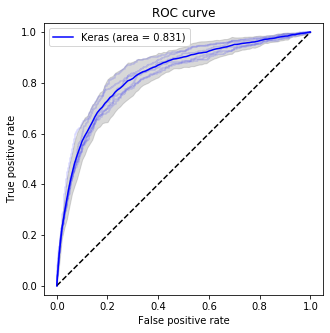

In [11]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


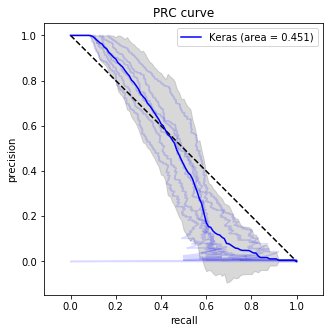

In [12]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [13]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))
print("overall auROC average " + str(np.mean(auroc_list)))
    
print("\n")

for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))
print("overall auPRC average " + str(np.mean(auprc_list)))

validated tissue forebrain auROC: 0.8490959671082174
validated tissue heart auROC: 0.8633359887712909
validated tissue hindbrain auROC: 0.81257927774121
validated tissue limb auROC: 0.8127331793357465
validated tissue midbrain auROC: 0.8333321491165744
validated tissue neural tube auROC: 0.8176710601446517
overall auROC average 0.8314579370362818


validated tissue forebrain auPRC: 0.5524086746326714
validated tissue heart auPRC: 0.4503304154527571
validated tissue hindbrain auPRC: 0.44378714763192867
validated tissue limb auPRC: 0.39790839962054486
validated tissue midbrain auPRC: 0.49467636123747394
validated tissue neural tube auPRC: 0.3641990183114029
overall auPRC average 0.4505516694811298
